# Multimodal video search using CLIP and LanceDB
We used LanceDB to store frames every thirty seconds and the title of 13000+ videos, 5 random from each top category from the Youtube 8M dataset.
Then, we used the CLIP model to embed frames and titles together. With LanceDB, we can perform embedding, keyword, and SQL search on these videosjpg)

### Install dependencies

In [1]:
!pip install --quiet -U lancedb
!pip install --quiet gradio transformers torch torchvision duckdb
!pip install tantivy@git+https://github.com/quickwit-oss/tantivy-py#164adc87e1a033117001cf70e38c82a53014d985

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.9/29.9 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.2/320.2 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.2/168.2 kB 8.9 MB/s eta 0:00:00
  Cloning https://github.com/quickwit-oss/tantivy-py to /tmp/pip-install-xgg2lyhx/tantivy_485320b633c341e5843407990b8c5411
  Running command git clone --filter=blob:none --quiet https://github.com/quickwit-oss/tantivy-py /tmp/pip-install-xgg2lyhx/tantivy_485320b633c341e5843407990b8c5411
 

## First run setup: Download data and pre-process

In [2]:
import duckdb
import lancedb

In [3]:
!wget https://vectordb-recipes.s3.us-west-2.amazonaws.com/multimodal_video_lance.tar.gz
!tar -xvf multimodal_video_lance.tar.gz
!mkdir -p data/video-lancedb
!mv multimodal_video.lance data/video-lancedb/

--2024-12-11 17:21:10--  https://vectordb-recipes.s3.us-west-2.amazonaws.com/multimodal_video_lance.tar.gz
Resolving vectordb-recipes.s3.us-west-2.amazonaws.com (vectordb-recipes.s3.us-west-2.amazonaws.com)... 3.5.80.19, 3.5.80.113, 52.92.154.186, ...
Connecting to vectordb-recipes.s3.us-west-2.amazonaws.com (vectordb-recipes.s3.us-west-2.amazonaws.com)|3.5.80.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 239974228 (229M) [application/x-gzip]
Saving to: ‘multimodal_video_lance.tar.gz’

multimodal_video_la 100%[===================>] 228.86M  44.1MB/s    in 5.7s    

2024-12-11 17:21:16 (40.0 MB/s) - ‘multimodal_video_lance.tar.gz’ saved [239974228/239974228]

multimodal_video.lance/
multimodal_video.lance/.DS_Store
multimodal_video.lance/_versions/
multimodal_video.lance/_latest.manifest
multimodal_video.lance/data/
multimodal_video.lance/_indices/
multimodal_video.lance/_indices/tantivy/
multimodal_video.lance/_indices/tantivy/9b278a8cf1c14b7f8c4c92a40bb7

## Create / Open LanceDB Table

In [4]:
db = lancedb.connect("data/video-lancedb")
tbl = db.open_table("multimodal_video")

## Create CLIP embedding function for the text
![clip](https://miro.medium.com/v2/resize:fit:3662/1*tg7akErlMSyCLQxrMtQIYw.png)
*CLIP model Architecuture.*

In [5]:
from transformers import CLIPModel, CLIPProcessor, CLIPTokenizerFast

MODEL_ID = "openai/clip-vit-base-patch32"

tokenizer = CLIPTokenizerFast.from_pretrained(MODEL_ID)
model = CLIPModel.from_pretrained(MODEL_ID)
processor = CLIPProcessor.from_pretrained(MODEL_ID)


def embed_func(query):
    inputs = tokenizer([query], padding=True, return_tensors="pt")
    text_features = model.get_text_features(**inputs)
    return text_features.detach().numpy()[0]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

## Search functions for Gradio

In [6]:
def find_video_vectors(query):
    emb = embed_func(query)
    code = (
        "import lancedb\n"
        "db = lancedb.connect('data/video-lancedb')\n"
        "tbl = db.open_table('multimodal_video')\n\n"
        f"embedding = embed_func('{query}')\n"
        "tbl.search(embedding).limit(9).to_pandas()"
    )
    return (_extract(tbl.search(emb).limit(9).to_pandas()), code)


# function to find the search for the video keywords from lancedb
def find_video_keywords(query):
    code = (
        "import lancedb\n"
        "db = lancedb.connect('data/video-lancedb')\n"
        "tbl = db.open_table('multimodal_video')\n\n"
        f"tbl.search('{query}').limit(9).to_pandas()"
    )
    return (_extract(tbl.search(query).limit(9).to_pandas()), code)


# create a SQL command to retrieve the video from the db
def find_video_sql(query):
    code = (
        "import lancedb\n"
        "import duckdb\n"
        "db = lancedb.connect('data/video-lancedb')\n"
        "tbl = db.open_table('multimodal_video')\n\n"
        "videos = tbl.to_lance()\n"
        f"duckdb.sql('{query}').to_pandas()"
    )
    videos = tbl.to_lance()
    return (_extract(duckdb.sql(query).to_pandas()), code)


# extract the video from the df
def _extract(df):
    video_id_col = "video_id"
    start_time_col = "start_time"
    grid_html = '<div style="display: grid; grid-template-columns: repeat(3, 1fr); grid-gap: 20px;">'

    for _, row in df.iterrows():
        iframe_code = f'<iframe width="100%" height="315" src="https://www.youtube.com/embed/{row[video_id_col]}?start={str(row[start_time_col])}" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>'
        grid_html += f'<div style="width: 100%;">{iframe_code}</div>'

    grid_html += "</div>"
    return grid_html

In [7]:
def find_video_vectors(query):
    emb = embed_func(query)
    code = (
        "import lancedb\n"
        "db = lancedb.connect('data/video-lancedb')\n"
        "tbl = db.open_table('multimodal_video')\n\n"
        f"embedding = embed_func('{query}')\n"
        "tbl.search(embedding).limit(9).to_pandas()"
    )
    return (_extract(tbl.search(emb).limit(9).to_pandas()), code)


def find_video_keywords(query):
    code = (
        "import lancedb\n"
        "db = lancedb.connect('data/video-lancedb')\n"
        "tbl = db.open_table('multimodal_video')\n\n"
        f"tbl.search('{query}').limit(9).to_pandas()"
    )
    return (_extract(tbl.search(query).limit(9).to_pandas()), code)


def find_video_sql(query):
    code = (
        "import lancedb\n"
        "import duckdb\n"
        "db = lancedb.connect('data/video-lancedb')\n"
        "tbl = db.open_table('multimodal_video')\n\n"
        "videos = tbl.to_lance()\n"
        f"duckdb.sql('{query}').to_pandas()"
    )
    videos = tbl.to_lance()
    return (_extract(duckdb.sql(query).to_pandas()), code)


def _extract(df):
    video_id_col = "video_id"
    start_time_col = "start_time"
    grid_html = '<div style="display: grid; grid-template-columns: repeat(3, 1fr); grid-gap: 20px;">'

    for _, row in df.iterrows():
        iframe_code = f'<iframe width="100%" height="315" src="https://www.youtube.com/embed/{row[video_id_col]}?start={str(row[start_time_col])}" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>'
        grid_html += f'<div style="width: 100%;">{iframe_code}</div>'

    grid_html += "</div>"
    return grid_html

## Setup Gradio interface
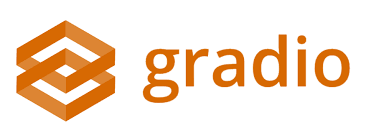

In [8]:
import gradio as gr

with gr.Blocks() as demo:
    gr.Markdown(
        """
            # Multimodal video search using CLIP and LanceDB
            We used LanceDB to store frames every thirty seconds and the title of 13000+ videos, 5 random from each top category from the Youtube 8M dataset.
            Then, we used the CLIP model to embed frames and titles together. With LanceDB, we can perform embedding, keyword, and SQL search on these videos.
            """
    )
    with gr.Row():
        with gr.Tab("Embeddings"):
            vector_query = gr.Textbox(value="retro gaming", show_label=False)
            b1 = gr.Button("Submit")
        with gr.Tab("Keywords"):
            keyword_query = gr.Textbox(value="ninja turtles", show_label=False)
            b2 = gr.Button("Submit")
        with gr.Tab("SQL"):
            sql_query = gr.Textbox(
                value="SELECT DISTINCT video_id, * from videos WHERE start_time > 0 LIMIT 9",
                show_label=False,
            )
            b3 = gr.Button("Submit")
    with gr.Row():
        code = gr.Code(label="Code", language="python")
    with gr.Row():
        gallery = gr.HTML()

    b1.click(find_video_vectors, inputs=vector_query, outputs=[gallery, code])
    b2.click(find_video_keywords, inputs=keyword_query, outputs=[gallery, code])
    b3.click(find_video_sql, inputs=sql_query, outputs=[gallery, code])

demo.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d05364fb54abbf29ce.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [10]:
!pip install --upgrade git+https://github.com/openai/CLIP.git
!pip install patchify
!pip install gdown

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-mra5jtcu
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-mra5jtcu
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.8 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=29389e224a77387e3acdc084a50b5cb81949154c3817f175691e9529cb361866
  Stored in directory: /tmp/pip-ephem-wheel-cache-9t3t3nl_/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [14]:
import os
import logging
import math
import cv2
import torch
import clip
from tqdm import tqdm
from transformers import CLIPModel, CLIPProcessor, CLIPTokenizerFast
import lancedb
import numpy as np
from PIL import Image
from patchify import patchify
import pandas as pd

# Check LanceDB setup and download data if missing
def setup_lancedb():
    db_path = "data/video-lancedb"
    table_name = "multimodal_video"

    if not os.path.exists(db_path):
        logging.info("Downloading LanceDB data...")
        os.makedirs(db_path, exist_ok=True)
        os.system("wget https://vectordb-recipes.s3.us-west-2.amazonaws.com/multimodal_video_lance.tar.gz")
        os.system("tar -xvf multimodal_video_lance.tar.gz")
        os.system(f"mv multimodal_video.lance {db_path}/")

    db = lancedb.connect(db_path)
    try:
        tbl = db.open_table(table_name)
    except FileNotFoundError:
        raise FileNotFoundError(f"Table '{table_name}' does not exist in {db_path}.")
    return tbl

# Hàm tìm video từ LanceDB
def find_videos_from_query(tbl, query, top_n=3):
    tokenizer = CLIPTokenizerFast.from_pretrained("openai/clip-vit-base-patch32")
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    inputs = tokenizer([query], padding=True, return_tensors="pt")
    text_features = model.get_text_features(**inputs).detach().numpy()[0]

    results = tbl.search(text_features).limit(top_n).to_pandas()
    return results

# Lớp xử lý video bằng CLIP
class ClipVideoProcessor:
    def __init__(self, model_name='RN50x4', patch_size=720//2):
        self.patch_size = patch_size
        self.patch_shape = (self.patch_size, self.patch_size, 3)
        self.patch_step = self.patch_size // 2
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        logging.info("Loading CLIP Model")
        self.clip_model, self.clip_prep = clip.load(model_name, self.device, jit=False)

    def process_video(self, video_path, query, top_frames=5):
        try:
            duration = self.get_video_duration(video_path)
            if duration == 0:
                raise ValueError("Video duration is zero. Please check the video file.")
            index_features, index_metadata = self.index_video(video_path, duration)
            query_features = self.get_query_features(query)

            matches = self.search(index_features, index_metadata, query_features, top_frames)
            self.show_results(matches, video_path)
        except Exception as e:
            logging.error(f"Error processing video: {e}")

    def index_video(self, video_path, duration, freq=1.0):
        index_features = None
        index_metadata = []
        last_index = 0

        with tqdm(total=math.ceil(duration)) as progress_bar:
            for frame, timestamp in self.video_frames(video_path):
                if timestamp - last_index > freq:
                    progress_bar.update(math.floor(timestamp) - progress_bar.n)
                    last_index = timestamp

                    patches = patchify(frame, self.patch_shape, self.patch_step).squeeze()
                    shape = patches.shape
                    patches = patches.reshape(shape[0] * shape[1], *self.patch_shape)

                    pils = [self.clip_prep(Image.fromarray(p)) for p in patches]
                    tensor = torch.stack(pils, dim=0).to(self.device)

                    with torch.no_grad():
                        frame_features = self.clip_model.encode_image(tensor)

                    frame_features /= frame_features.norm(dim=-1, keepdim=True)

                    if index_features is not None:
                        index_features = torch.cat((index_features, frame_features), dim=0)
                    else:
                        index_features = frame_features

                    index_metadata.extend([{'path': video_path, 't': timestamp}] * len(patches))

        return index_features, index_metadata

    def search(self, index_features, index_metadata, query_features, top_n=5, threshold=35):
        similarity = (100.0 * query_features @ index_features.T)
        values, indices = similarity[0].topk(min(top_n * 10, len(index_metadata)))

        result = []
        time = 0
        for d in zip(values, indices):
            meta = index_metadata[d[1]]
            if len(result) < top_n and d[0] > threshold and abs(meta['t'] - time) > 0.1:
                time = meta['t']
                result.append({'score': float(d[0]), 'path': meta['path'], 't': meta['t']})

        return result

    def get_query_features(self, query):
        query_tensor = torch.cat([clip.tokenize(query)]).to(self.device)
        with torch.no_grad():
            query_features = self.clip_model.encode_text(query_tensor)
        query_features /= query_features.norm(dim=-1, keepdim=True)
        return query_features

    def get_video_duration(self, path):
        video = cv2.VideoCapture(path)
        fps = video.get(cv2.CAP_PROP_FPS)
        frame_count = video.get(cv2.CAP_PROP_FRAME_COUNT)
        if fps == 0:
            raise ValueError("FPS is zero. Cannot calculate duration.")
        return frame_count / fps

    def video_frames(self, path):
        video = cv2.VideoCapture(path)
        fps = video.get(cv2.CAP_PROP_FPS)
        ret, frame = video.read()
        count = 0
        while ret:
            count += 1
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            yield frame, count / fps
            ret, frame = video.read()

    def show_results(self, matches, video_path):
        if len(matches) > 0:
            rows = int(math.ceil(len(matches) / 2))
            fig, ax = plt.subplots(rows, 2, figsize=(20, rows * 6))
            a = ax.ravel()

            for i, m in enumerate(matches):
                frame = self.get_video_frame(video_path, m['t'])
                a[i].imshow(frame)
                a[i].set_title('time:{} score:{}'.format(round(m['t'], 1), round(m['score'], 2)))
            for ax in fig.axes:
                ax.axis("off")
            plt.tight_layout()
            plt.show()

    def get_video_frame(self, path, timestamp):
        video = cv2.VideoCapture(path)
        video.set(cv2.CAP_PROP_POS_MSEC, timestamp * 1000)
        ret, frame = video.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        return frame if ret else None

# Main workflow
def main():
    logging.basicConfig(level=logging.INFO)

    query = input("Enter your query: ")

    # Step 1: Tìm video từ LanceDB
    try:
        tbl = setup_lancedb()
    except FileNotFoundError as e:
        print(e)
        return

    video_results = find_videos_from_query(tbl, query, top_n=3)

    if video_results.empty:
        print("No videos found for the query.")
        return

    # Step 2: Tải và xử lý video
    clip_processor = ClipVideoProcessor()
    for _, row in video_results.iterrows():
        video_id = row['video_id']
        video_url = f"https://www.youtube.com/watch?v={video_id}"
        print(f"Processing video: {video_url}")
        # Add your logic to download the video locally here.
        # For demo purposes, assuming video_path is available.
        video_path = "path_to_downloaded_video.mp4"
        clip_processor.process_video(video_path, query)

if __name__ == "__main__":
    main()


Enter your query: a dog


ERROR:root:Error processing video: FPS is zero. Cannot calculate duration.
ERROR:root:Error processing video: FPS is zero. Cannot calculate duration.
ERROR:root:Error processing video: FPS is zero. Cannot calculate duration.


Processing video: https://www.youtube.com/watch?v=N0BYyxApUS0
Processing video: https://www.youtube.com/watch?v=19rWZojaOK8
Processing video: https://www.youtube.com/watch?v=0NJKPVcGQ6Q


In [20]:
pip install yt-dlp


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.1/172.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 38.6 MB/s eta 0:00:00


Enter your query: a dog
Processing video: https://www.youtube.com/watch?v=N0BYyxApUS0


 99%|█████████▊| 136/138 [02:02<00:01,  1.11it/s]


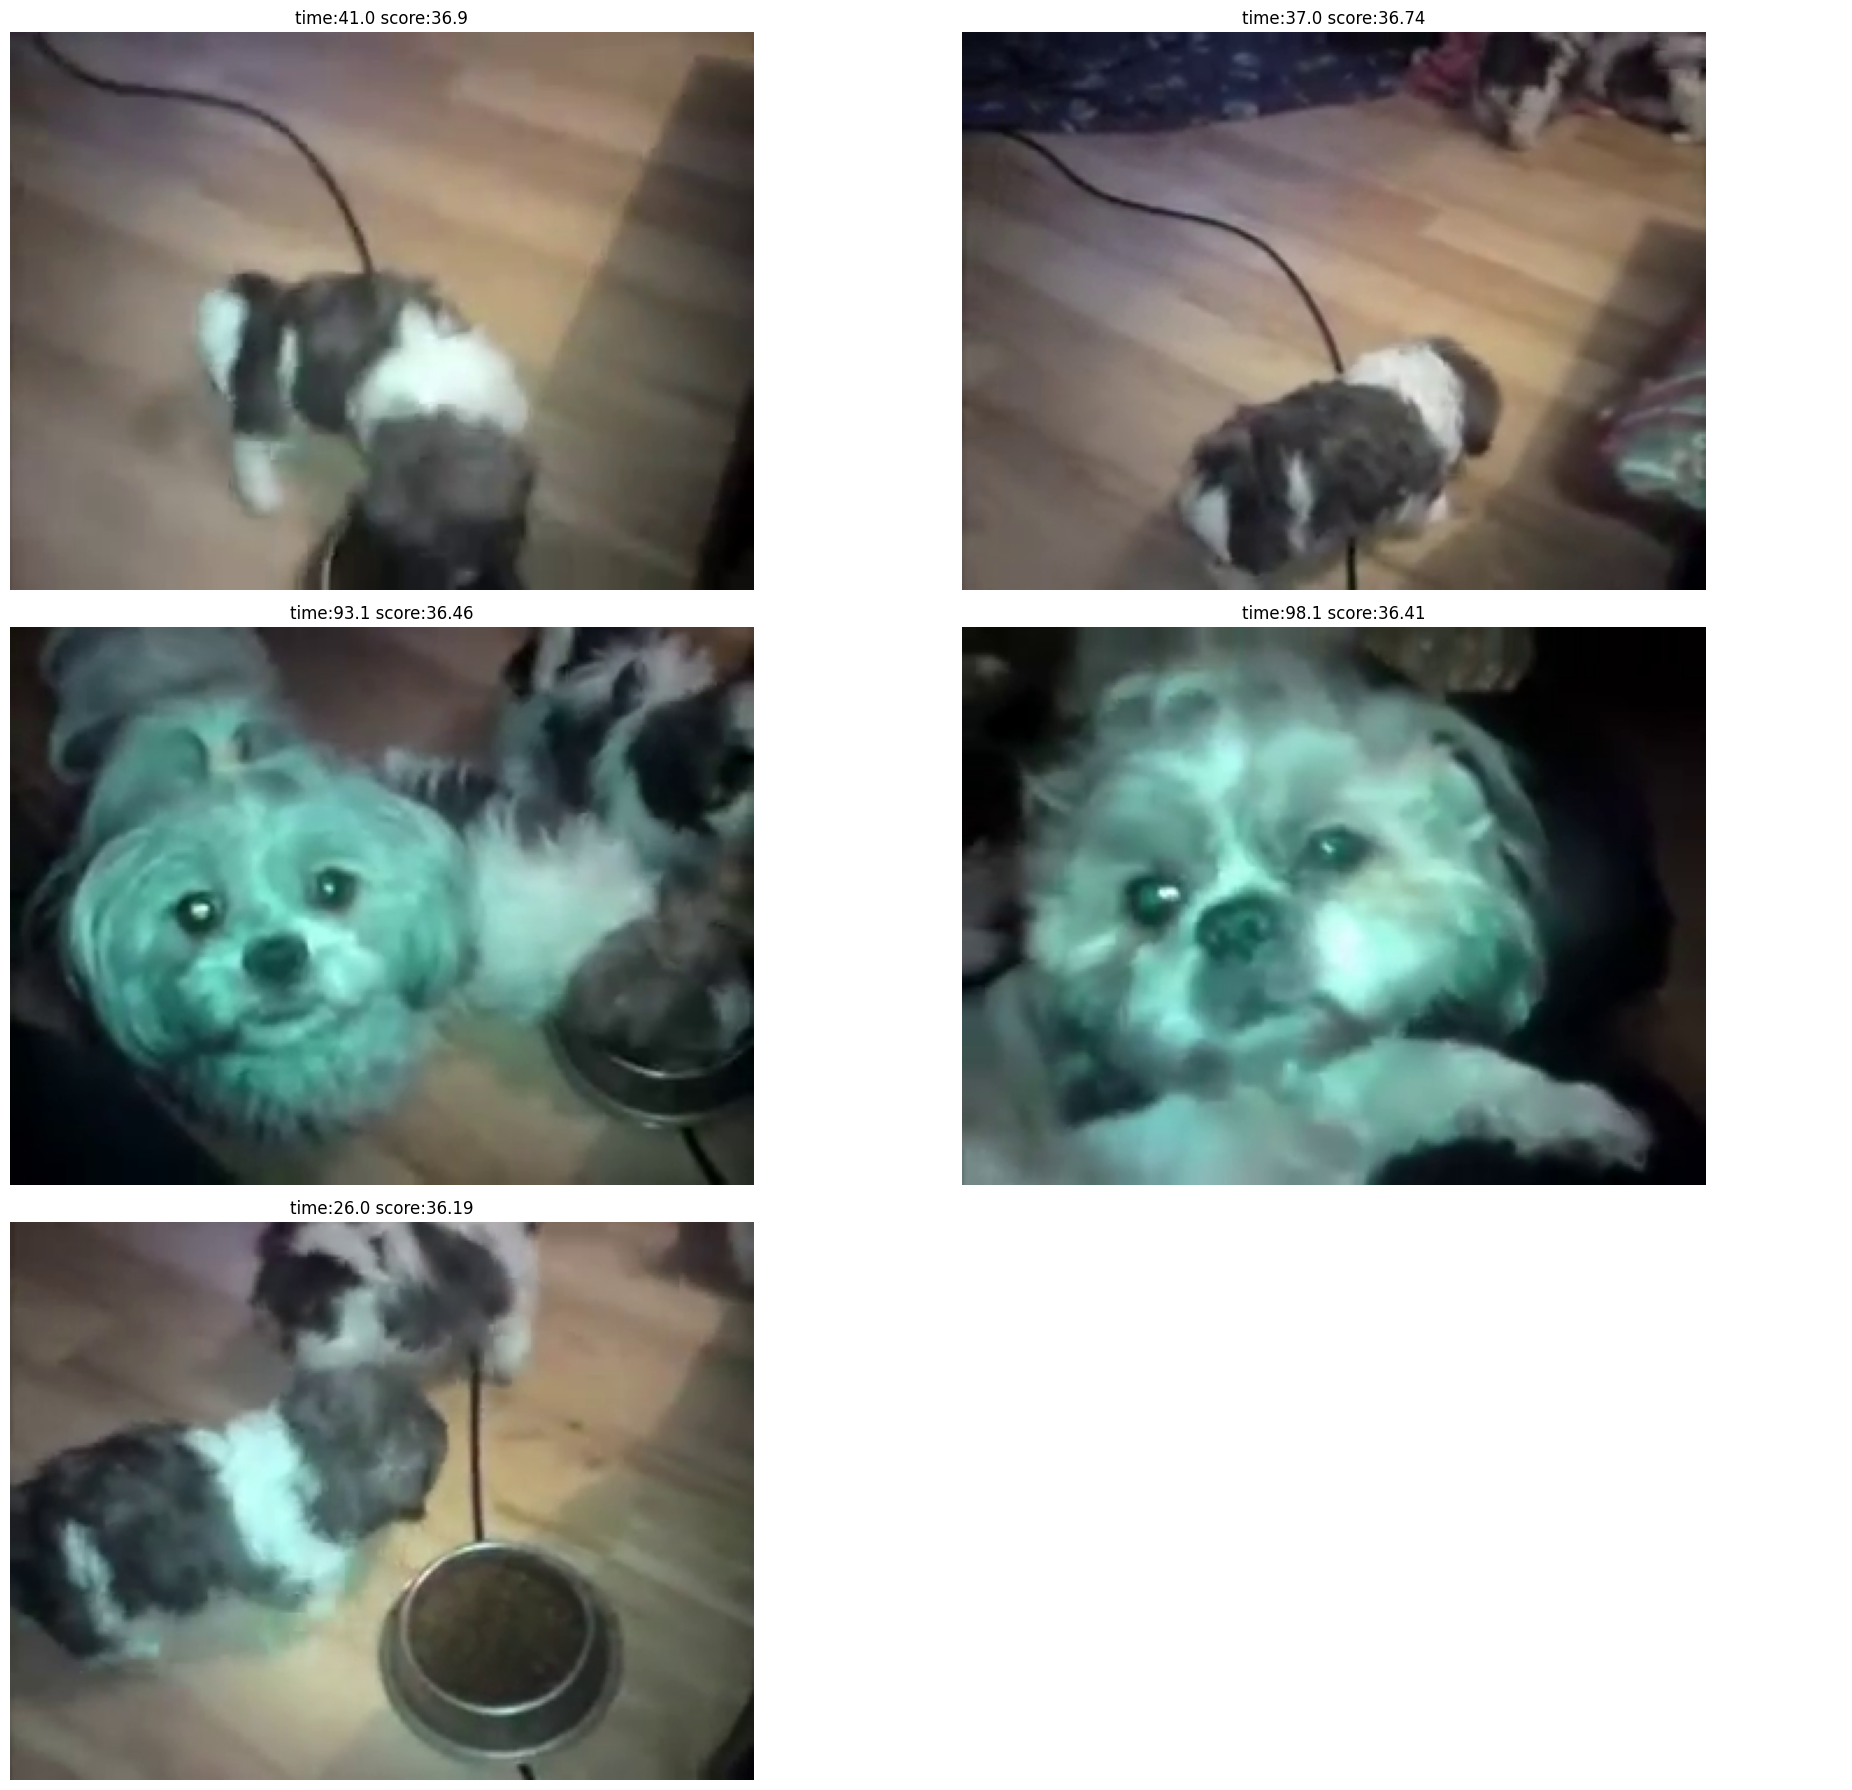

Processing video: https://www.youtube.com/watch?v=19rWZojaOK8


 98%|█████████▊| 125/127 [01:46<00:01,  1.17it/s]


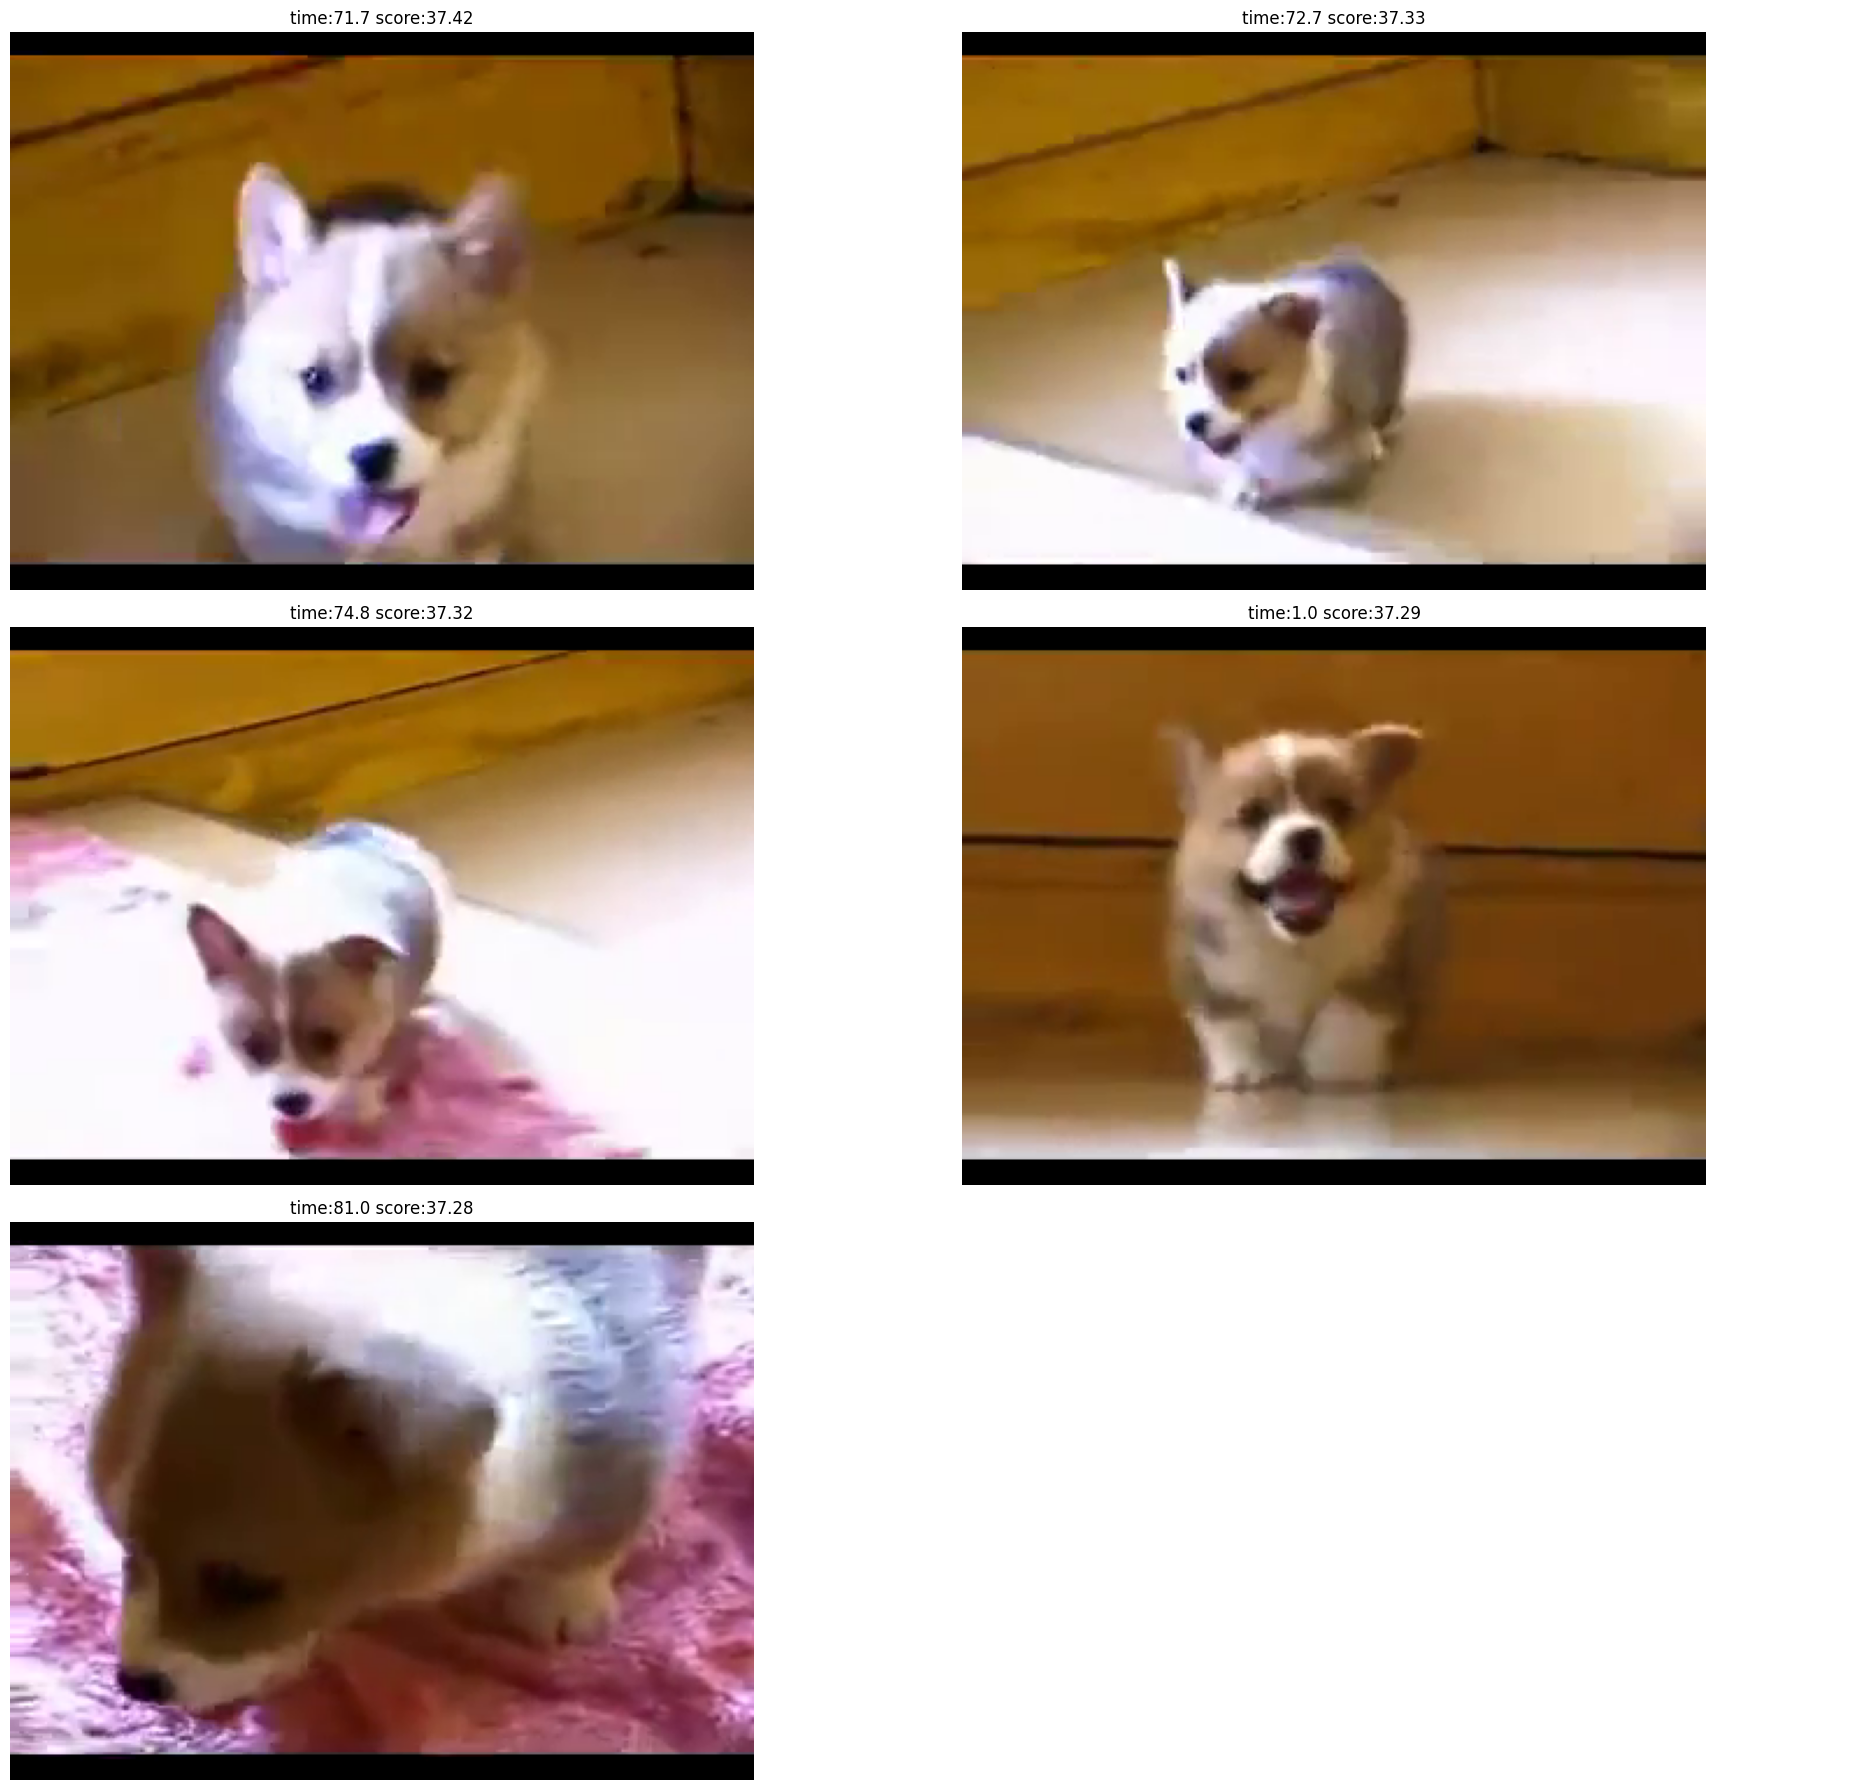

Processing video: https://www.youtube.com/watch?v=0NJKPVcGQ6Q


100%|█████████▉| 250/251 [03:47<00:00,  1.10it/s]


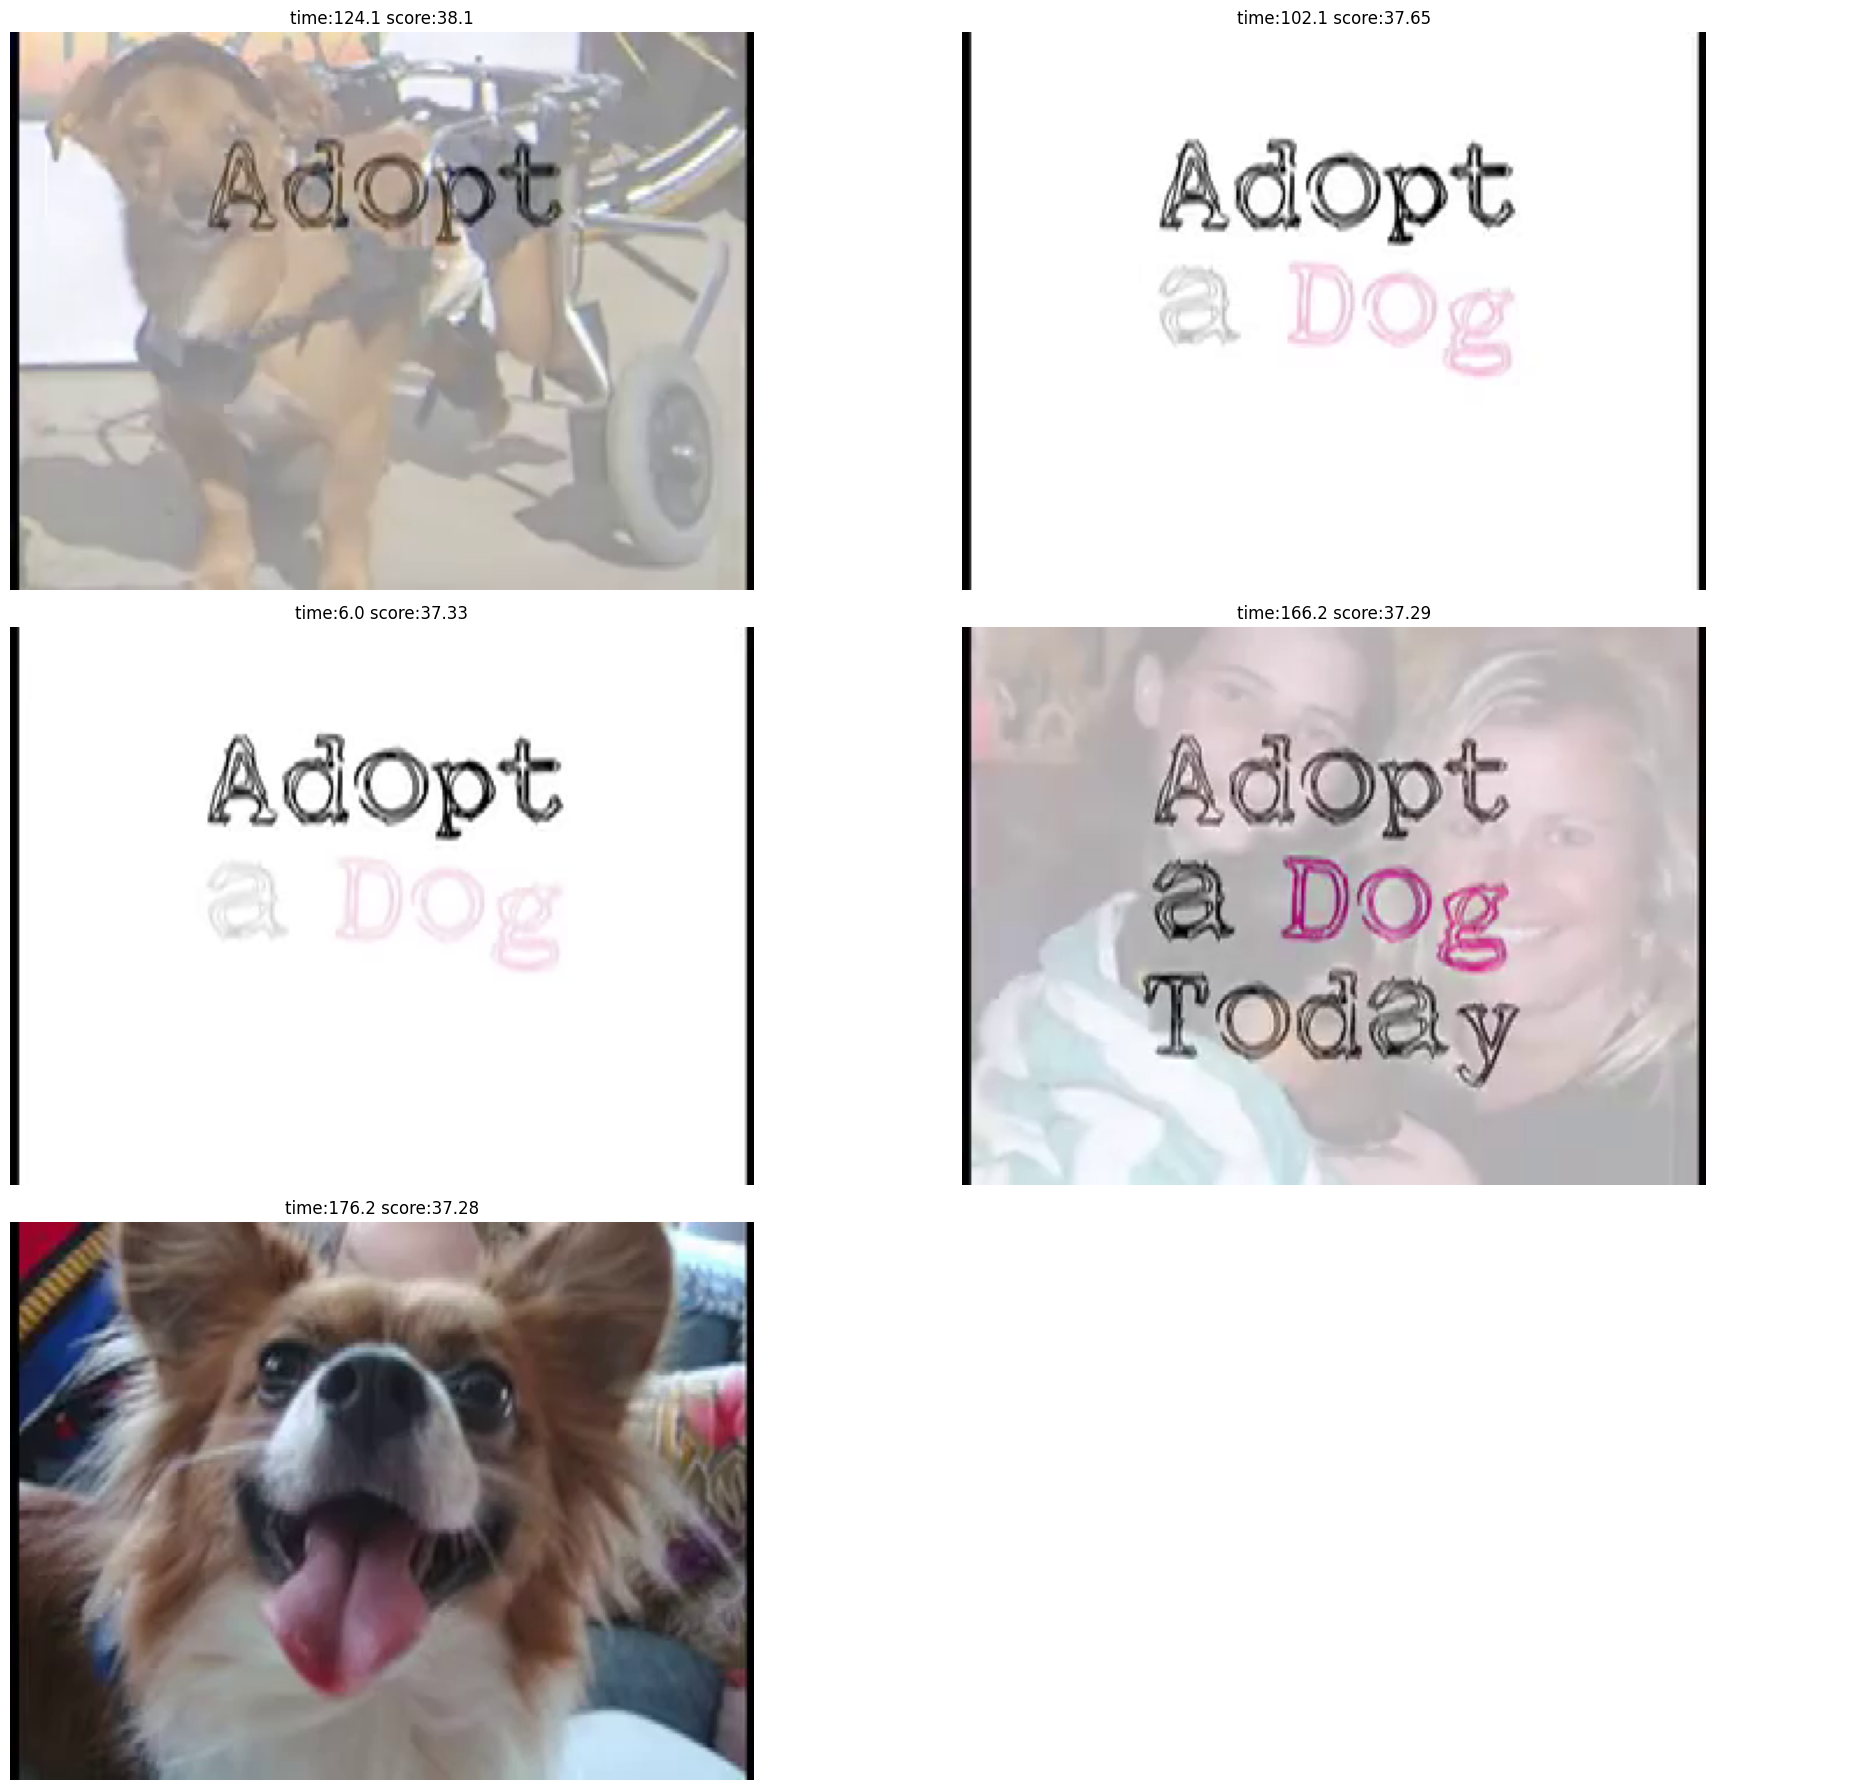

In [24]:
import os
import logging
import math
import cv2
import torch
import clip
from tqdm import tqdm
from transformers import CLIPModel, CLIPProcessor, CLIPTokenizerFast
import lancedb
import numpy as np
from PIL import Image
from patchify import patchify
import pandas as pd
import yt_dlp
from matplotlib import pyplot as plt


# Check LanceDB setup and download data if missing
def setup_lancedb():
    db_path = "data/video-lancedb"
    table_name = "multimodal_video"

    if not os.path.exists(db_path):
        logging.info("Downloading LanceDB data...")
        os.makedirs(db_path, exist_ok=True)
        os.system("wget https://vectordb-recipes.s3.us-west-2.amazonaws.com/multimodal_video_lance.tar.gz")
        os.system("tar -xvf multimodal_video_lance.tar.gz")
        os.system(f"mv multimodal_video.lance {db_path}/")

    db = lancedb.connect(db_path)
    try:
        tbl = db.open_table(table_name)
    except FileNotFoundError:
        raise FileNotFoundError(f"Table '{table_name}' does not exist in {db_path}.")
    return tbl

# Hàm tìm video từ LanceDB
def find_videos_from_query(tbl, query, top_n=3):
    tokenizer = CLIPTokenizerFast.from_pretrained("openai/clip-vit-base-patch32")
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    inputs = tokenizer([query], padding=True, return_tensors="pt")
    text_features = model.get_text_features(**inputs).detach().numpy()[0]

    results = tbl.search(text_features).limit(top_n).to_pandas()
    return results

# Lớp xử lý video bằng CLIP
class ClipVideoProcessor:
    def __init__(self, model_name='RN50x4', patch_size=720//2):
        self.patch_size = patch_size
        self.patch_shape = (self.patch_size, self.patch_size, 3)
        self.patch_step = self.patch_size // 2
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        logging.info("Loading CLIP Model")
        self.clip_model, self.clip_prep = clip.load(model_name, self.device, jit=False)

    def process_video(self, video_path, query, top_frames=5):
        try:
            duration = self.get_video_duration(video_path)
            if duration == 0:
                raise ValueError("Video duration is zero. Please check the video file.")
            index_features, index_metadata = self.index_video(video_path, duration)
            query_features = self.get_query_features(query)

            matches = self.search(index_features, index_metadata, query_features, top_frames)
            self.show_results(matches, video_path)
        except Exception as e:
            logging.error(f"Error processing video: {e}")

    def index_video(self, video_path, duration, freq=1.0):
        index_features = None
        index_metadata = []
        last_index = 0

        with tqdm(total=math.ceil(duration)) as progress_bar:
            for frame, timestamp in self.video_frames(video_path):
                if timestamp - last_index > freq:
                    progress_bar.update(math.floor(timestamp) - progress_bar.n)
                    last_index = timestamp

                    # Ensure patch size is valid for the frame
                    frame_height, frame_width, _ = frame.shape
                    if frame_height < self.patch_shape[0] or frame_width < self.patch_shape[1]:
                        scale_factor = min(frame_height / self.patch_shape[0], frame_width / self.patch_shape[1])
                        self.patch_shape = (
                            int(self.patch_shape[0] * scale_factor),
                            int(self.patch_shape[1] * scale_factor),
                            3
                        )
                        self.patch_step = max(1, self.patch_shape[0] // 2)
                        logging.warning(f"Adjusted patch size to {self.patch_shape} to fit frame dimensions.")

                    try:
                        patches = patchify(frame, self.patch_shape, self.patch_step)
                        shape = patches.shape
                        patches = patches.reshape(-1, *self.patch_shape)
                    except ValueError as e:
                        logging.error(f"Error patchifying frame: {e}. Skipping frame.")
                        continue

                    pils = [self.clip_prep(Image.fromarray(p)) for p in patches]
                    tensor = torch.stack(pils, dim=0).to(self.device)

                    with torch.no_grad():
                        frame_features = self.clip_model.encode_image(tensor)

                    frame_features /= frame_features.norm(dim=-1, keepdim=True)

                    if index_features is not None:
                        index_features = torch.cat((index_features, frame_features), dim=0)
                    else:
                        index_features = frame_features

                    index_metadata.extend([{'path': video_path, 't': timestamp}] * len(patches))

        return index_features, index_metadata

    def search(self, index_features, index_metadata, query_features, top_n=5, threshold=35):
        similarity = (100.0 * query_features @ index_features.T)
        values, indices = similarity[0].topk(min(top_n * 10, len(index_metadata)))

        result = []
        time = 0
        for d in zip(values, indices):
            meta = index_metadata[d[1]]
            if len(result) < top_n and d[0] > threshold and abs(meta['t'] - time) > 0.1:
                time = meta['t']
                result.append({'score': float(d[0]), 'path': meta['path'], 't': meta['t']})

        return result

    def get_query_features(self, query):
        query_tensor = torch.cat([clip.tokenize(query)]).to(self.device)
        with torch.no_grad():
            query_features = self.clip_model.encode_text(query_tensor)
        query_features /= query_features.norm(dim=-1, keepdim=True)
        return query_features

    def get_video_duration(self, path):
        video = cv2.VideoCapture(path)
        fps = video.get(cv2.CAP_PROP_FPS)
        frame_count = video.get(cv2.CAP_PROP_FRAME_COUNT)
        if fps == 0:
            raise ValueError("FPS is zero. Cannot calculate duration.")
        return frame_count / fps

    def video_frames(self, path):
        video = cv2.VideoCapture(path)
        fps = video.get(cv2.CAP_PROP_FPS)
        ret, frame = video.read()
        count = 0
        while ret:
            count += 1
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            yield frame, count / fps
            ret, frame = video.read()

    def show_results(self, matches, video_path):
        if len(matches) > 0:
            rows = int(math.ceil(len(matches) / 2))
            fig, ax = plt.subplots(rows, 2, figsize=(20, rows * 6))
            a = ax.ravel()

            for i, m in enumerate(matches):
                frame = self.get_video_frame(video_path, m['t'])
                a[i].imshow(frame)
                a[i].set_title('time:{} score:{}'.format(round(m['t'], 1), round(m['score'], 2)))
            for ax in fig.axes:
                ax.axis("off")
            plt.tight_layout()
            plt.show()

    def get_video_frame(self, path, timestamp):
        video = cv2.VideoCapture(path)
        video.set(cv2.CAP_PROP_POS_MSEC, timestamp * 1000)
        ret, frame = video.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        return frame if ret else None

# Function to download video from YouTube
def download_video(video_url, output_path="videos"):
    os.makedirs(output_path, exist_ok=True)
    file_path = os.path.join(output_path, f"{video_url.split('=')[-1]}.mp4")
    ydl_opts = {
        'format': 'best[ext=mp4]',
        'outtmpl': file_path,
        'quiet': True,
    }
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        ydl.download([video_url])
    logging.info(f"Downloaded video to {file_path}")
    return file_path

# Main workflow
def main():
    logging.basicConfig(level=logging.INFO)

    query = input("Enter your query: ")

    # Step 1: Tìm video từ LanceDB
    try:
        tbl = setup_lancedb()
    except FileNotFoundError as e:
        print(e)
        return

    video_results = find_videos_from_query(tbl, query, top_n=3)

    if video_results.empty:
        print("No videos found for the query.")
        return

    # Step 2: Tải và xử lý video
    clip_processor = ClipVideoProcessor()
    for _, row in video_results.iterrows():
        video_id = row['video_id']
        video_url = f"https://www.youtube.com/watch?v={video_id}"
        print(f"Processing video: {video_url}")

        # Tải video từ YouTube
        video_path = download_video(video_url)

        # Xử lý video đã tải
        clip_processor.process_video(video_path, query)

if __name__ == "__main__":
    main()


In [ ]:
import os
import logging
import math
import cv2
import torch
import clip
from tqdm import tqdm
from transformers import CLIPModel, CLIPProcessor, CLIPTokenizerFast
import lancedb
import numpy as np
from PIL import Image
from patchify import patchify
import pandas as pd
import yt_dlp
from matplotlib import pyplot as plt

# Check LanceDB setup and download data if missing
def setup_lancedb():
    db_path = "data/video-lancedb"
    table_name = "multimodal_video"

    if not os.path.exists(db_path):
        logging.info("Downloading LanceDB data...")
        os.makedirs(db_path, exist_ok=True)
        os.system("wget https://vectordb-recipes.s3.us-west-2.amazonaws.com/multimodal_video_lance.tar.gz")
        os.system("tar -xvf multimodal_video_lance.tar.gz")
        os.system(f"mv multimodal_video.lance {db_path}/")

    db = lancedb.connect(db_path)
    try:
        tbl = db.open_table(table_name)
    except FileNotFoundError:
        raise FileNotFoundError(f"Table '{table_name}' does not exist in {db_path}.")
    return tbl

# Hàm tìm video từ LanceDB
def find_videos_from_query(tbl, query, top_n=3):
    tokenizer = CLIPTokenizerFast.from_pretrained("openai/clip-vit-base-patch32")
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    inputs = tokenizer([query], padding=True, return_tensors="pt")
    text_features = model.get_text_features(**inputs).detach().numpy()[0]

    results = tbl.search(text_features).limit(top_n).to_pandas()
    return results

# Lớp xử lý video bằng CLIP
class ClipVideoProcessor:
    def __init__(self, model_name='RN50x4', patch_size=720//2):
        self.patch_size = patch_size
        self.patch_shape = (self.patch_size, self.patch_size, 3)
        self.patch_step = self.patch_size // 2
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        logging.info("Loading CLIP Model")
        self.clip_model, self.clip_prep = clip.load(model_name, self.device, jit=False)

    def process_video(self, video_path, query, top_frames=5):
        try:
            duration = self.get_video_duration(video_path)
            if duration == 0:
                raise ValueError("Video duration is zero. Please check the video file.")
            index_features, index_metadata = self.index_video(video_path, duration)
            query_features = self.get_query_features(query)

            matches = self.search(index_features, index_metadata, query_features, top_frames)
            self.show_results(matches, video_path)
        except Exception as e:
            logging.error(f"Error processing video: {e}")

    def index_video(self, video_path, duration, freq=1.0):
        index_features = None
        index_metadata = []
        last_index = 0

        with tqdm(total=math.ceil(duration)) as progress_bar:
            for frame, timestamp in self.video_frames(video_path):
                if timestamp - last_index > freq:
                    progress_bar.update(math.floor(timestamp) - progress_bar.n)
                    last_index = timestamp

                    # Ensure patch size is valid for the frame
                    frame_height, frame_width, _ = frame.shape
                    if frame_height < self.patch_shape[0] or frame_width < self.patch_shape[1]:
                        scale_factor = min(frame_height / self.patch_shape[0], frame_width / self.patch_shape[1])
                        self.patch_shape = (
                            int(self.patch_shape[0] * scale_factor),
                            int(self.patch_shape[1] * scale_factor),
                            3
                        )
                        self.patch_step = max(1, self.patch_shape[0] // 2)
                        logging.warning(f"Adjusted patch size to {self.patch_shape} to fit frame dimensions.")

                    try:
                        patches = patchify(frame, self.patch_shape, self.patch_step)
                        shape = patches.shape
                        patches = patches.reshape(-1, *self.patch_shape)
                    except ValueError as e:
                        logging.error(f"Error patchifying frame: {e}. Skipping frame.")
                        continue

                    pils = [self.clip_prep(Image.fromarray(p)) for p in patches]
                    tensor = torch.stack(pils, dim=0).to(self.device)

                    with torch.no_grad():
                        frame_features = self.clip_model.encode_image(tensor)

                    frame_features /= frame_features.norm(dim=-1, keepdim=True)

                    if index_features is not None:
                        index_features = torch.cat((index_features, frame_features), dim=0)
                    else:
                        index_features = frame_features

                    index_metadata.extend([{'path': video_path, 't': timestamp}] * len(patches))

        return index_features, index_metadata

    def search(self, index_features, index_metadata, query_features, top_n=5, threshold=35):
        similarity = (100.0 * query_features @ index_features.T)
        values, indices = similarity[0].topk(min(top_n * 10, len(index_metadata)))

        result = []
        time = 0
        for d in zip(values, indices):
            meta = index_metadata[d[1]]
            if len(result) < top_n and d[0] > threshold and abs(meta['t'] - time) > 0.1:
                time = meta['t']
                result.append({'score': float(d[0]), 'path': meta['path'], 't': meta['t']})

        return result

    def get_query_features(self, query):
        query_tensor = torch.cat([clip.tokenize(query)]).to(self.device)
        with torch.no_grad():
            query_features = self.clip_model.encode_text(query_tensor)
        query_features /= query_features.norm(dim=-1, keepdim=True)
        return query_features

    def get_video_duration(self, path):
        video = cv2.VideoCapture(path)
        fps = video.get(cv2.CAP_PROP_FPS)
        frame_count = video.get(cv2.CAP_PROP_FRAME_COUNT)
        if fps == 0:
            raise ValueError("FPS is zero. Cannot calculate duration.")
        return frame_count / fps

    def video_frames(self, path):
        video = cv2.VideoCapture(path)
        fps = video.get(cv2.CAP_PROP_FPS)
        ret, frame = video.read()
        count = 0
        while ret:
            count += 1
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            yield frame, count / fps
            ret, frame = video.read()

    def show_results(self, matches, video_path):
        if len(matches) > 0:
            rows = int(math.ceil(len(matches) / 2))
            fig, ax = plt.subplots(rows, 2, figsize=(20, rows * 6))
            a = ax.ravel()

            for i, m in enumerate(matches):
                frame = self.get_video_frame(video_path, m['t'])
                a[i].imshow(frame)
                a[i].set_title('time:{} score:{}'.format(round(m['t'], 1), round(m['score'], 2)))
            for ax in fig.axes:
                ax.axis("off")
            plt.tight_layout()
            plt.show()

    def get_video_frame(self, path, timestamp):
        video = cv2.VideoCapture(path)
        video.set(cv2.CAP_PROP_POS_MSEC, timestamp * 1000)
        ret, frame = video.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        return frame if ret else None

# Function to download video from YouTube
def download_video(video_url, output_path="videos"):
    os.makedirs(output_path, exist_ok=True)
    file_path = os.path.join(output_path, f"{video_url.split('=')[-1]}.mp4")
    ydl_opts = {
        'format': 'best[ext=mp4]',
        'outtmpl': file_path,
        'quiet': True,
    }
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        ydl.download([video_url])
    logging.info(f"Downloaded video to {file_path}")
    return file_path

# Main workflow
def main():
    logging.basicConfig(level=logging.INFO)

    query = input("Enter your query: ")

    # Step 1: Tìm video từ LanceDB
    try:
        tbl = setup_lancedb()
    except FileNotFoundError as e:
        print(e)
        return

    video_results = find_videos_from_query(tbl, query, top_n=3)

    if video_results.empty:
        print("No videos found for the query.")
        return

    # Step 2: Tải và xử lý video
    clip_processor = ClipVideoProcessor()
    for _, row in video_results.iterrows():
        video_id = row['video_id']
        video_url = f"https://www.youtube.com/watch?v={video_id}"
        print(f"Processing video: {video_url}")

        # Tải video từ YouTube
        video_path = download_video(video_url)

        # Xử lý video đã tải
        clip_processor.process_video(video_path, query)

if __name__ == "__main__":
    main()
